# Assignment 6
In this assignment, I would like you to develop a random forest to classify the MNIST dataset.  Here are the basic requirements:
1.  This is a multi-class problem: the random forest should classify all 10 digits.
2.   As we did with the pulsar data, I want you to use k-fold validation, as well as the error curve, to determine the optimal depth for the trees used in the forest.
3.  I want you to look at feature performance.   In the case of MNIST, the features are the pixels.   I would like you to determine the ranked importance of all of the pixels, and then make a heatmap (using plotly) along the lines of the plot in the book (Chapter 7, figure 7-6).

This assignment is essentially a combination of parts of the "multiclassV2.ipynb" workbook, as well as the "forest_mtru2.ipynb" workbook. 

Use the structure below to craft your solution.

# Some Useful Methods

In [1]:
from collections import defaultdict
from functools import partial
from itertools import repeat
def nested_defaultdict(default_factory, depth=1):
    result = partial(defaultdict, default_factory)
    for _ in repeat(None, depth - 1):
        result = partial(defaultdict, result)
    return result()

from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)
%matplotlib inline


def getDecisionTreeGraphic(estimator,feature_names,class_names):
  from sklearn import tree
  from io import StringIO
  import pydot_ng as pydot 
  import graphviz
  import matplotlib.pyplot as plt

  dot_data = StringIO()

  #                         class_names=classColumn,
  out = tree.export_graphviz(estimator,out_file=None,
                           feature_names=feature_names,
                           class_names=class_names,
                           filled=True, rounded=True,
                           special_characters=True,
                            node_ids=1,)
  import pydotplus
  pydot_graph = pydotplus.graph_from_dot_data(out)
  pydot_graph.set_size('"7,7!"')
  #print(pydot_graph.getvalue())
  #graph = graphviz.Source( out)
  graph = graphviz.Source(pydot_graph.to_string())
  return graph

## Get the data

In [16]:
import pandas as pd
#
# Define our "signal" digit
short = ""
#short = "short_"

#
# Read in all of the other digits
dfCombined = pd.DataFrame()
for digit in range(10):
    print("Processing digit ",digit)
    fname = '/fs/scratch/PAS1585/ch3/digit_' + short + str(digit) + '.csv'
    df = pd.read_csv(fname,header=None)
    df['digit'] = digit
    dfCombined = pd.concat([dfCombined, df])

print("Length of sample:     ",len(dfCombined))


Processing digit  0
Processing digit  1
Processing digit  2
Processing digit  3
Processing digit  4
Processing digit  5
Processing digit  6
Processing digit  7
Processing digit  8
Processing digit  9
Length of sample:      70000


In [3]:
dfCombined.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,digit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## The Performance Method.
Get this from the multiclassV2 workbook.   Remember that the multiclass performance method does not return AUC as a performance metric.   I suggest using "macro accuracy".

In [4]:
# Determine the performance
def multiPerformance(y,y_pred,y_score):

# Make our matrix
    confusionMatrix = nested_defaultdict(int,2)
    classes = set()
    totalTrue = defaultdict(int)
    totalPred = defaultdict(int)

    for i in range(len(y_pred)):
        trueClass = y[i]
        classes.add(trueClass)
        predClass = y_pred[i]
        totalTrue[trueClass] += 1
        totalPred[predClass] += 1
        confusionMatrix[trueClass][predClass] += 1
        
    recall = 0
    precision = 0
    auc = 0
    
    for trueClass in classes:
        
        TP = confusionMatrix[trueClass][trueClass]
        
        for predClass in classes:
            
            if predClass != trueClass:
                
                FP = confusionMatrix[predClass][trueClass]
                FN = confusionMatrix[trueClass][predClass]
                TN = confusionMatrix[predClass][predClass]
        
        
        recall += TP / (TP + FN)
        precision += TP / (TP + FP)
        
    RecallMacro = recall/len(classes)
    PrecisionMacro = precision/len(classes)
        
    results = {"confusionMatrix":confusionMatrix,"RecallMacro":RecallMacro,"PrecisionMacro":PrecisionMacro}

        
    return results

## The Runfitter Method
Get this from the multiclassV2 notebook.

In [5]:
def runFitter(estimator,X_train,y_train,X_test,y_test):
#
# Now fit to our training set
  estimator.fit(X_train,y_train)
#
# Now predict the classes and get the score for our traing set
  y_train_pred = estimator.predict(X_train)
  y_train_score = estimator.predict_proba(X_train)[:,1]   # NOTE: some estimators have a predict_prob method instead od descision_function
#
# Now predict the classes and get the score for our test set
  y_test_pred = estimator.predict(X_test)
  y_test_score = estimator.predict_proba(X_test)[:,1]

#
# Now get the performaance
  results_test = multiPerformance(y_test,y_test_pred,y_test_score)
  results_train = multiPerformance(y_train,y_train_pred,y_train_score)
#
# Decide what you want to return: for now, just precision, recall, and auc for both test and train
  results = {
      'recall_test':results_test['RecallMacro'],
      'precision_test':results_test['PrecisionMacro'],
      'recall_train':results_train['RecallMacro'],
      'precision_train':results_train['PrecisionMacro'],
}

  return results
  

## Prepare the data
Remember that the features (X) are the first 784 columns, and the labels (y) are given by the "digit" column.

In [6]:
from sklearn.utils import shuffle
dfCombinedShuffle = shuffle(dfCombined,random_state=42)    # by setting the random state we will get reproducible results

X = dfCombinedShuffle.as_matrix(columns=dfCombinedShuffle.columns[:784])
y = dfCombinedShuffle['digit'].values

/apps/project/ondemand/python/3.6-conda5.2/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



## Run the fitter once
Use a reasonable set of parameters for the forest estimator: for example, n_estimators=100, max_depth=5.  The perform one run of k-fold validation to see what sort of accuracy you get.   An average macro accuracy of 86% on the test set is reasonable with these parameters.

In [7]:
from sklearn.model_selection import StratifiedKFold
kfolds = 5
skf = StratifiedKFold(n_splits=kfolds)

In [8]:
from sklearn.ensemble import RandomForestClassifier
estimator = RandomForestClassifier(n_estimators=100, max_depth=6,random_state=42)

avg_precision_train = 0.0
avg_recall_train = 0.0
avg_auc_train = 0.0
avg_precision_test = 0.0
avg_recall_test = 0.0
avg_auc_test = 0.0
numSplits = 0.0
#
# Now loop
for train_index, test_index in skf.split(X, y):
  numSplits += 1
  X_train = X[train_index]
  y_train = y[train_index]
  X_test = X[test_index]
  y_test = y[test_index]
  
#
# Now fit to our training set
  results = runFitter(estimator,X_train,y_train,X_test,y_test)

  avg_precision_train += results['precision_train']
  avg_recall_train += results['recall_train']

#
  avg_precision_test += results['precision_test']
  avg_recall_test += results['recall_test']
#
avg_precision_train /= numSplits
avg_recall_train /= numSplits

avg_precision_test /= numSplits
avg_recall_test /= numSplits
# 
# Now print
print("Precision train/test ",round(avg_precision_train,3),round(avg_precision_test,3))
print("Recall train/test    ",round(avg_recall_train,3),round(avg_recall_test,3))

Precision train/test  0.985 0.984
Recall train/test     0.977 0.974


## Finding the Optimal max_depth
Here you want to loop from max_depth=2 to 22.   You could do this in increments of 2 (2,4,6,8..,20,22) to save time.   Save the performance (macro_accuracy) at each max_depth.

In [9]:
#
# Get our estimator and predict
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
#
# Create a dataframe to store our results
dfError = pd.DataFrame(columns=['max_depth','trainError_pre','testError_pre',
                                    'trainError_rec','testError_rec'])

for max_depth in range(2,24,2):
  print("training with max depth =",max_depth)
  estimator = RandomForestClassifier(n_estimators=100,random_state=42,max_depth=max_depth)
  avg_precision_train = 0.0
  avg_recall_train = 0.0
  avg_precision_test = 0.0
  avg_recall_test = 0.0
  numSplits = 0.0
#
# Now loop
  for train_index, test_index in skf.split(X, y):
    numSplits += 1
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]

#
# Now fit to our training set
    results = runFitter(estimator,X_train,y_train,X_test,y_test)
    #print("results",results)

    avg_precision_train += results['precision_train']
    avg_recall_train += results['recall_train']

#
    avg_precision_test += results['precision_test']
    avg_recall_test += results['recall_test']

#
  avg_precision_train /= numSplits
  avg_recall_train /= numSplits
  avg_precision_test /= numSplits
  avg_recall_test /= numSplits
#
# Fill dataframe
  dfError = dfError.append({
     'max_depth':max_depth,
     'trainError_pre':1.0-avg_precision_train,'testError_pre':1.0-avg_precision_test,
     'trainError_rec':1.0-avg_recall_train,'testError_rec':1.0-avg_recall_test,
     'trainError_auc':1.0-avg_auc_train,'testError_auc':1.0-avg_auc_test
      }, ignore_index=True)
# 
# Now print
dfError.head()

training with max depth = 2
training with max depth = 4
training with max depth = 6
training with max depth = 8
training with max depth = 10
training with max depth = 12
training with max depth = 14
training with max depth = 16
training with max depth = 18
training with max depth = 20
training with max depth = 22


,max_depth,trainError_pre,testError_pre,trainError_rec,testError_rec,testError_auc,trainError_auc
0,2.0,0.055485,0.057466,0.053665,0.052935,1.0,1.0
1,4.0,0.026425,0.026934,0.037615,0.039121,1.0,1.0
2,6.0,0.014504,0.016216,0.023167,0.026335,1.0,1.0
3,8.0,0.007445,0.011882,0.011737,0.019032,1.0,1.0
4,10.0,0.002779,0.009398,0.003945,0.014756,1.0,1.0


## Plot accuracy vs max_depth
This plot should have both train and test results on it.   And it should be obvious what the final max_depth choice should be.

In [10]:
import plotly.plotly as py
import numpy as np
from plotly.offline import iplot
import plotly.graph_objs as go

# Create a trace
trace1 = go.Scatter(
    x = dfError['max_depth'],
    y = dfError['trainError_pre'],
    mode = 'lines',
    name = "Training error"
)
# Create a trace
trace2 = go.Scatter(
    x = dfError['max_depth'],
    y = dfError['testError_pre'],
    mode = 'lines',
    name = "Testing Error"
)

layout = dict(
    title='Error (Precision) vs Model Complexity',
    xaxis=dict(title='max_depth'),
    yaxis=dict(title='Error (fraction)')
)

data = [trace1, trace2]
iplot(dict(data=data,layout=layout),validate=False)

# Create a trace
trace1 = go.Scatter(
    x = dfError['max_depth'],
    y = dfError['trainError_rec'],
    mode = 'lines',
    name = "Training error"
)
# Create a trace
trace2 = go.Scatter(
    x = dfError['max_depth'],
    y = dfError['testError_rec'],
    mode = 'lines',
    name = "Testing Error"
)

layout = dict(
    title='Error (Recall) vs Model Complexity',
    xaxis=dict(title='max_depth'),
    yaxis=dict(title='Error (fraction)')
)

data = [trace1, trace2]
iplot(dict(data=data,layout=layout),validate=False)


## Feature importance
As noted above, we want to find the feature importance of the pixels.   However, we want to do this with the **final** model.   What is the final model?   The model with the ideal max_depth that we determined above.   So you will want to re-train the model, using this max_depth, as well as the **full** data.   Look at how this is done at the end of "forest_htru2.ipynb".

Also, to plot the feature importance of the pixels, you will have to reshape the returned importances (with are of length 784) to an array of shape (28,28).   Then you can plot them as a heatmap.   Use google to find the appropriate plotly commands (google "plotly heatmap").

Also, are you sure that the orientation of the heatmap is correct?   Come up with a way of checking this.

In [12]:
from sklearn.utils import shuffle
dfCombinedShuffle = shuffle(dfCombined,random_state=42)    # by setting the random state we will get reproducible results

X = dfCombinedShuffle.as_matrix(columns=dfCombinedShuffle.columns[:784])
y = dfCombinedShuffle['digit'].values

estimator = RandomForestClassifier(n_estimators=100,random_state=42,max_depth=12)

results = runFitter(estimator,X,y,X,y)

print("Precision:",results['precision_train'])
print("Recall:   ",results['recall_train'])


/apps/project/ondemand/python/3.6-conda5.2/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



Precision: 0.9991987893553503
Recall:    0.9990984950761659


<class 'numpy.ndarray'>


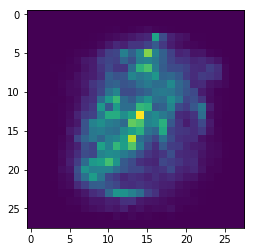

In [15]:
import matplotlib.pyplot as plt
img = estimator.feature_importances_     # grab the pixel info
img = img.reshape(28,28)
print(type(img))
plt.imshow(img)

In [17]:
len(X)

10000